# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# import Ridge
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False, ngram_range=(1,2),analyzer='word',stop_words='english')
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    

    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/toeyscn/Downloads/ml-master/final_assignment_1/toxiccomments_train.csv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_hinge")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12970, 'TN': 114645, 'FP': 17, 'FN': 24, 'Accuracy': 0.9996788243404149, 'Precision': 0.9986909986909986, 'Recall': 0.9981529936893951, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [ ]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='log',n_jobs = -1, max_iter=1200,alpha=0.000000001,fit_intercept = False,class_weight = 'balanced',n_iter_no_change = 15)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

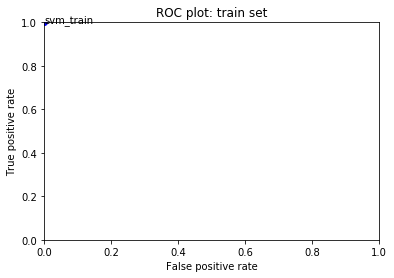

In [145]:
fits = [svm_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()



### MODEL: SVM.SVC

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'Pos': 12994, 'Neg': 114662, 'TP': 12968, 'TN': 114653, 'FP': 9, 'FN': 26, 'Accuracy': 0.9997258256564517, 'Precision': 0.9993064652847345, 'Recall': 0.9979990764968447, 'desc': 'svc_train1.0'}
{'Pos': 12994, 'Neg': 114662, 'TP': 12975, 'TN': 114648, 'FP': 14, 'FN': 19, 'Accuracy': 0.9997414927617974, 'Precision': 0.998922164908769, 'Recall': 0.9985377866707711, 'desc': 'svc_train0.1'}
{'Pos': 12994, 'Neg': 114662, 'TP': 12973, 'TN': 114648, 'FP': 14, 'FN': 21, 'Accuracy': 0.9997258256564517, 'Precision': 0.998921998921999, 'Recall': 0.9983838694782207, 'desc': 'svc_train0.001'}
{'Pos': 12994, 'Neg': 114662, 'TP': 12971, 'TN': 114653, 'FP': 9, 'FN': 23, 'Accuracy': 0.9997493263144701, 'Precision': 0.999306625577812, 'Recall': 0.9982299522856704, 'desc': 'svc_train0.0001'}
{'Pos': 12994, 'Neg': 114662, 'TP': 12960, 'TN': 114652, 'FP': 10, 'FN': 34, 'Accuracy': 0.9996553236823964, 'Precision': 0.9992289899768697, 'Recall': 0.997383407726643, 'desc': 'svc_train1e-05'}


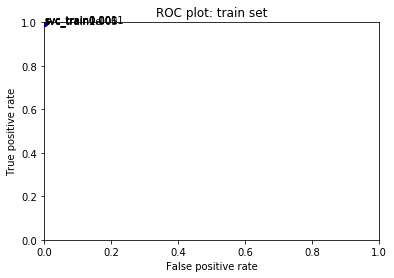

In [65]:
from sklearn.svm import LinearSVC

c_values = [1.0,0.1,0.001,0.0001,0.00001]
performance_measures =[]

for c in c_values: 
    svc = LinearSVC(C=c)
    svc.fit(X_train, y_train)

    svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train'+ str(c))
    svc_performance_train.compute_measures()
    performance_measures.append(svc_performance_train)

    print(svc_performance_train.performance_measures)


for measures in performance_measures:
    plt.plot(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], 'bo')
    plt.text(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], measures.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


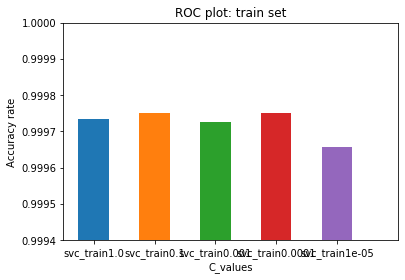

In [53]:

import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset
# data = {'C':20, 'C++':15, 'Java':30,
#         'Python':35}
# courses = list(data.keys())
# values = list(data.values())
  
# fig = plt.figure(figsize = (10, 5))


 
# creating the bar plot

for measures in performance_measures:

    plt.bar(measures.desc, 
            measures.performance_measures['Accuracy'],
           width = 0.5)

#     plt.text(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
#                  measures.performance_measures['TP'] / measures.performance_measures['Pos'], measures.desc)

    plt.axis([-0.5,5, 0.9994, 1])



plt.xlabel("C_values")
plt.ylabel("Accuracy rate")
plt.title("ROC plot: train set")
plt.show()


### MODEL: logistic regression

In [83]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12968, 'TN': 114647, 'FP': 15, 'FN': 26, 'Accuracy': 0.9996788243404149, 'Precision': 0.9988446429946853, 'Recall': 0.9979990764968447, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [111]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=1.0e-10)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12982, 'TN': 113386, 'FP': 1276, 'FN': 12, 'Accuracy': 0.989910384157423, 'Precision': 0.9105063823818207, 'Recall': 0.9990764968446976, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [112]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12959, 'TN': 114644, 'FP': 18, 'FN': 35, 'Accuracy': 0.9995848217083412, 'Precision': 0.9986129305694691, 'Recall': 0.9973064491303678, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [164]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=10)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12974, 'TN': 114647, 'FP': 15, 'FN': 20, 'Accuracy': 0.9997258256564517, 'Precision': 0.9988451766879668, 'Recall': 0.9984608280744959, 'desc': 'rdg_train'}


In [166]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=7)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12970, 'TN': 114652, 'FP': 10, 'FN': 24, 'Accuracy': 0.9997336592091245, 'Precision': 0.9992295839753467, 'Recall': 0.9981529936893951, 'desc': 'rdg_train'}


In [8]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=50)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12970, 'TN': 114652, 'FP': 10, 'FN': 24, 'Accuracy': 0.9997336592091245, 'Precision': 0.9992295839753467, 'Recall': 0.9981529936893951, 'desc': 'rdg_train'}


In [172]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=20)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12971, 'TN': 114652, 'FP': 10, 'FN': 23, 'Accuracy': 0.9997414927617974, 'Precision': 0.9992296433248594, 'Recall': 0.9982299522856704, 'desc': 'rdg_train'}


In [195]:
from sklearn.linear_model import RidgeCV
# from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

rdg_performance_train = rdg.predict(X_train, y_train, 'rdg_train')


# Standarize features
scaler = StandardScaler()
X_std = scaler.fit_transform(rdg_performance_train)

# Create ridge regression with three possible alpha values
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])

# Fit the linear regression
model_cv = regr_cv.fit(X_std,y_train)

# View alpha
model_cv.alpha_

TypeError: predict() takes 2 positional arguments but 4 were given

### MODEL: Random Forest Classifier

In [131]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=500,n_jobs = -1,random_state =200)

rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)


{'Pos': 12994, 'Neg': 114662, 'TP': 9624, 'TN': 114662, 'FP': 0, 'FN': 3370, 'Accuracy': 0.9736009274926365, 'Precision': 1.0, 'Recall': 0.7406495305525628, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

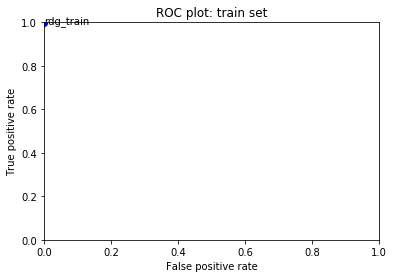

In [168]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


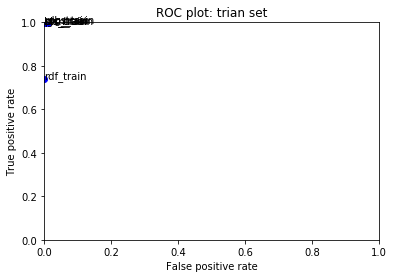

In [157]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: trian set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [148]:
ols_predictions = ols.predict(X_train)

In [149]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
13313
Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey guys I love chicken rice=)Hey g

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [137]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1661, 'TN': 27589, 'FP': 1095, 'FN': 1570, 'Accuracy': 0.9164969450101833, 'Precision': 0.6026850507982583, 'Recall': 0.514082327452801, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [146]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2438, 'TN': 22954, 'FP': 5730, 'FN': 793, 'Accuracy': 0.7956133479555069, 'Precision': 0.2984818805093046, 'Recall': 0.7545651501083256, 'desc': 'svm_test'}


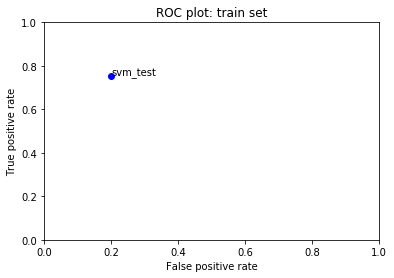

In [147]:
fits = [svm_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()



/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'Pos': 3231, 'Neg': 28684, 'TP': 3231, 'TN': 28684, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svc_test1.0'}
{'Pos': 3231, 'Neg': 28684, 'TP': 3230, 'TN': 28684, 'FP': 0, 'FN': 1, 'Accuracy': 0.9999686667711107, 'Precision': 1.0, 'Recall': 0.9996904982977406, 'desc': 'svc_test0.1'}
{'Pos': 3231, 'Neg': 28684, 'TP': 3230, 'TN': 28684, 'FP': 0, 'FN': 1, 'Accuracy': 0.9999686667711107, 'Precision': 1.0, 'Recall': 0.9996904982977406, 'desc': 'svc_test0.001'}
{'Pos': 3231, 'Neg': 28684, 'TP': 3230, 'TN': 28684, 'FP': 0, 'FN': 1, 'Accuracy': 0.9999686667711107, 'Precision': 1.0, 'Recall': 0.9996904982977406, 'desc': 'svc_test0.0001'}
{'Pos': 3231, 'Neg': 28684, 'TP': 3229, 'TN': 28684, 'FP': 0, 'FN': 2, 'Accuracy': 0.9999373335422215, 'Precision': 1.0, 'Recall': 0.9993809965954813, 'desc': 'svc_test1e-05'}


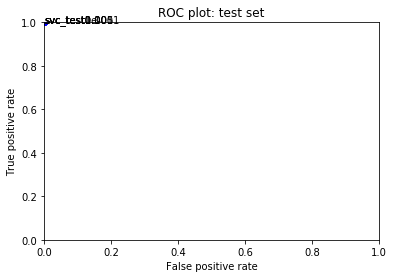

In [66]:

from sklearn.svm import LinearSVC

c_values = [1.0,0.1,0.001,0.0001,0.00001]
performance_measures =[]

for c in c_values: 
    svc = LinearSVC(C=c)
    svc.fit(X_test, y_test)

    svc_performance_test = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test'+ str(c))
    svc_performance_test.compute_measures()
    performance_measures.append(svc_performance_test)

    print(svc_performance_test.performance_measures)


for measures in performance_measures:
    plt.plot(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], 'bo')
    plt.text(measures.performance_measures['FP'] / measures.performance_measures['Neg'], 
             measures.performance_measures['TP'] / measures.performance_measures['Pos'], measures.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()





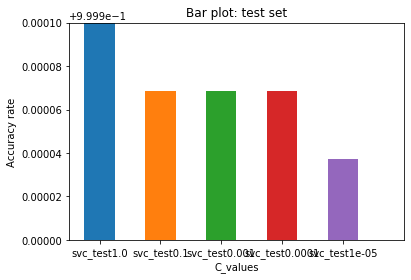

In [64]:

import numpy as np
import matplotlib.pyplot as plt
 
  
# creating the dataset


for measures in performance_measures:

    plt.bar(measures.desc, 
            measures.performance_measures['Accuracy'],
           width = 0.5)

    plt.axis([-0.5,5, 0.9999, 1])



plt.xlabel("C_values")
plt.ylabel("Accuracy rate")
plt.title("Bar plot: test set")
plt.show()

### MODEL: logistic regression

In [139]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1686, 'TN': 27541, 'FP': 1143, 'FN': 1545, 'Accuracy': 0.9157762807457308, 'Precision': 0.5959703075291622, 'Recall': 0.5218198700092851, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [140]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 430, 'TN': 28191, 'FP': 493, 'FN': 2801, 'Accuracy': 0.8967883440388532, 'Precision': 0.4658721560130011, 'Recall': 0.13308573197152584, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [141]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1614, 'TN': 27755, 'FP': 929, 'FN': 1617, 'Accuracy': 0.9202255992480025, 'Precision': 0.6346834447502949, 'Recall': 0.49953574744661094, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [169]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1051, 'TN': 28505, 'FP': 179, 'FN': 2180, 'Accuracy': 0.9260849130502898, 'Precision': 0.8544715447154472, 'Recall': 0.3252862890745899, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [143]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1061, 'TN': 28667, 'FP': 17, 'FN': 2170, 'Accuracy': 0.9314742284192385, 'Precision': 0.9842300556586271, 'Recall': 0.3283813060971835, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

In [1]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

NameError: name 'rdg_performance_test' is not defined

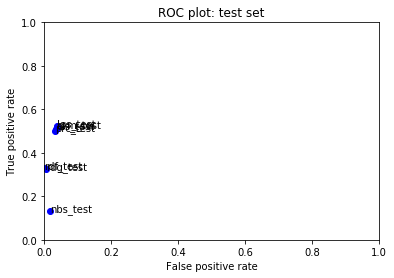

In [144]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [72]:
from sklearn.svm import LinearSVC


svc = LinearSVC(C = 1.0)
svc.fit(X_test, y_test)

svc_performance_test = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test'+ 
svc_performance_test.compute_measures()

print(svc_performance_test)


                                                           
fits = [svc_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()



SyntaxError: invalid syntax (<ipython-input-72-e6d93679bcdf>, line 10)

In [67]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/toeyscn/Downloads/ml-master/final_assignment_1/toxiccomments_test.csv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6      

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [68]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svc.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.0756770520487843


In [69]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [70]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,False
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [153]:
my_submission.shape

(153164, 2)

In [155]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/toeyscn/Downloads/ml-master/final_assignment_1/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation